**베이즈 통계**: 조건부 확률과 비조건부 확률을 연계시키는 베이즈 정리에 기반   
**베이즈 정리**: 새로운 관찰을 한 후에 이 지식을 업데이트하기 위한 지식 제공   
**확률적 프로그래밍**: 베이즈 추론 방법을 사용한 통계적 문제 해결 방법   
**확률적 프로그래밍의 주요 단계**
1. 통계적 모델 생성
2. MCMC 방식을 사용해 관심 대상 수량에 대한 사후 분포의 표본 추출
3. 사후 분포를 사용해 당면 문제에 대한 관심 성질을 계산하고 그 결과에 따라 추론

## 모듈 임포트하기

In [1]:
import pymc3 as mc 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

## 베이즈 통계 소개
베이즈 통계학의 기초는 베이즈 정리로 두 사건 A와 B 사이의 비조건화 및 조건부 확률 관계 설정   

베이즈 규칙은 일반적으로 사건 A에 대한 사전 믿음    
-> 무조건 확률 P(A)를 갖고 있는 상황에서 사건 B를 관측하고 난 후에 A에 대한 믿음을 업데이트하고자 할 경우에 사용   

**P(A|B)** : 사건 B를 관측한 경우의 A의 사후 확률

## 모델 정의
통계적 모델은 일련의 확률 변수로 정의   
-> 주어진 모델의 확률 변수는 독립적일 수도 있고 종속적일 수도 있음

**PyMC 라이브러리**: 여러 확률 분포로 확률 변수를 표현하기 위한 클래스 제공

In [2]:
# 고정된 매개변수인 정규 분포를 따르는 단일 확률 변수로 구성된 모델에 관심이 있다고 가정
# 고정된 모델 매개변수 정의
mu = 4.0
sigma = 2.0
model = mc.Model() # 모델 인스턴스 생성
# 문맥 내에서 확률 변수 생성해 모델에 첨가
with model:
    mc.Normal('X', mu, tau=1/sigma**2)

# 모델에 존재하는 확률 변수 검사
model.vars

[X ~ Normal]

In [3]:
# 시작 지점을 매개변숫값으로 갖는 딕셔너리 전달
start = dict(X=2)
with model:
    step = mc.Metropolis() # 구현된 MCMC 표본 추출의 step 메서드
    trace = mc.sample(10000, step=step, start=start) # 표본 개수, step 클래스, 시작점

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


위 단계를 통해 모델 내에서 정의된 확률 변수에서 10000개의 값을 표본으로 추출했는데 이 예제의 경우 모두 정규분포 확률 변수

In [4]:
# 표본에 접근
X = trace.get_values("X")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


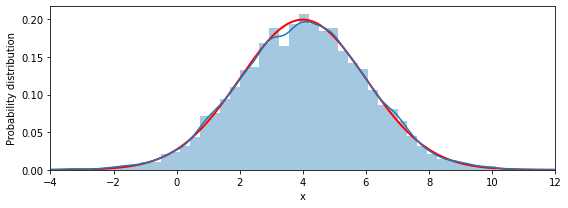

In [5]:
# 정규분포 확률 변수
x = np.linspace(-4, 12, 1000)
y = stats.norm(mu, sigma).pdf(x)
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel("x")
ax.set_ylabel("Probability distribution")
fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  after removing the cwd from sys.path.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


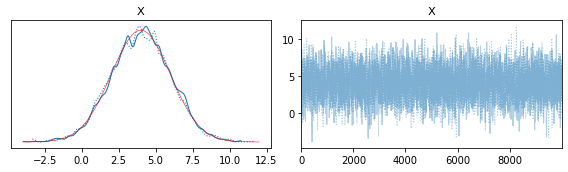

In [6]:
# 왼쪽: 표본 추적의 밀도 커널 추정과 정규 확률 분포
# 오른쪽: MCMC 표본 추출 추적
fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), squeeze=False)
mc.traceplot(trace, axes=axes)
axes[0, 0].plot(x, y, 'r', lw=0.5)
fig.tight_layout()

In [7]:
# 매개변수 변경하여 정규분포 확률 변수 생성
model = mc.Model()
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sd=1.0)
    X = mc.Normal('X', mean, tau=sigma)

In [8]:
# 어떤 확률 변수가 모델에 포함돼있는지 검사
model.vars

[mean ~ Normal, sigma_log__ ~ TransformedDistribution, X ~ Normal]

In [9]:
# 매개 변수 공간에서 사후 분포의 최댓값에 해당하는 점 찾기
with model:
    start = mc.find_MAP()
start

{'mean': array(3.),
 'sigma_log__': array(-0.34657365),
 'X': array(3.),
 'sigma': array(0.70710674)}

In [10]:
# 위에서 모델이 지정되고 시작점이 계산되면
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, start=start, step=step) # 모델에서 확률 변수 추출

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [11]:
# sigma 변수에 대한 표본 trace 배열의 평균
trace.get_values('sigma').mean()

0.7900814457974086

In [12]:
# 동일한 방식으로 X의 표본을 입수하고 표본의 통계량 산출
X = trace.get_values('X')
X.mean()

3.099965575242072

In [13]:
# 표준 편차
trace.get_values('X').std()

2.52963776681031

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


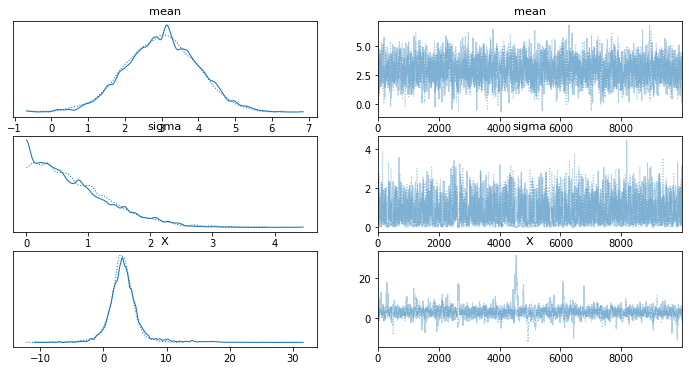

In [14]:
# 세 가지 확률 변수(mean, sigma, X)에 대한 KDE와 mcmc 랜덤 표본 추출 trace
#fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, var_names=['mean', 'sigma', 'X'])
fig.tight_layout()

### 사후 분포 표본 추출
지금까지는 모델 정의 후 관찰된 데이터는 고려하지 않고 확률 변수를 모델에서 추출    
-> MCMC 기법을 사용하여 모델의 사전 분포로부터 표본을 추출

그러나 MCMC의 진짜 응용 분야는 관측값 고려 후 사전 분포를 업데이트한 후의 분포로부터 표본 추출


In [15]:
# 정규 분포 확률에서 표본 추출에 X에 대한 시뮬레이션
mu = 2.5
s = 1.5
data = stats.norm(mu, s).rvs(100)

In [16]:
# 관측 변수 생성되어 모델에 추가
with mc.Model() as model:
    
    mean = mc.Normal('mean', 4.0, tau=1.0) # true 2.5
    sigma = mc.HalfNormal('sigma', tau=3.0 * np.sqrt(np.pi/2)) # true 1.5
    X = mc.Normal('X', mean, tau=1/sigma**2, observed=data) # 모델에 데이터 입력

# 모델 검사
model.vars

[mean ~ Normal, sigma_log__ ~ TransformedDistribution]

위의 결과를 통해 X는 mean과 sigma로 나타나는 사전 분포와 연계된 우도 함수를 구성하는 확정 변수라고 생성

In [17]:
# mc.sample 사용하여 모델의 사후 분포로부터 표본 추출
with model:
    start = mc.find_MAP()
    step = mc.Metropolis()
    trace = mc.sample(10000, start=start, step=step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [18]:
# 계산한 시작점: 주어진 관측값에서 사후 분포의 우도를 최대화하고 사전 분포의 미지의 매개변수 추정값 산출
start

{'mean': array(2.46743705),
 'sigma_log__': array(0.39331958),
 'sigma': array(1.4818919)}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


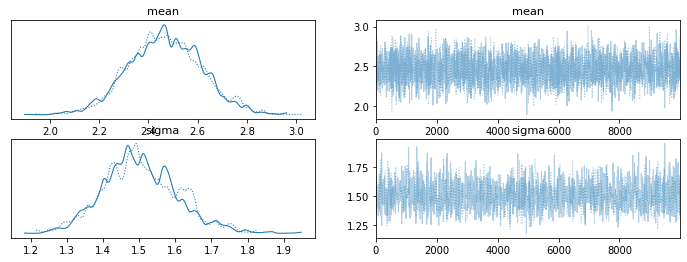

In [19]:
# 사후 분포 표본의 추출 결과
#fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace, var_names=['mean', 'sigma'])
fig.tight_layout()

In [20]:
# 사후 분포에서 추출된 표본을 이용해 통계량과 수치 추정
mu, trace.get_values('mean').mean()

(2.5, 2.4673306485931694)

In [21]:
s, trace.get_values('sigma').mean()

(1.5, 1.5035242990721782)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


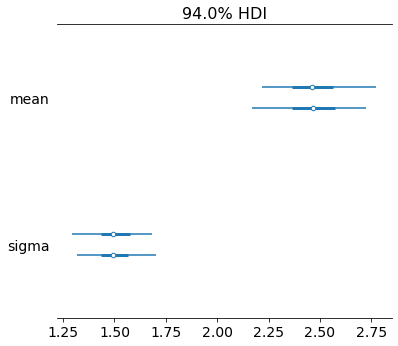

In [22]:
# 모델의 각 확률 변수를 그 평균과 신뢰도 구간으로 시각화
gs = mc.forestplot(trace, var_names=['mean', 'sigma'])

In [23]:
mc.summary(trace, var_names=['mean', 'sigma'])

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,2.467,0.148,2.208,2.766,0.003,0.002,2988.0,2651.0,1.0
sigma,1.504,0.103,1.322,1.714,0.003,0.002,1526.0,1446.0,1.0


### 선형 회귀

In [24]:
# 남녀 200명 키와 몸무게 데이터 로드
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [25]:
data = dataset.data[dataset.data.sex == 'M'] # 남자 대상자에 해당하는 부분 집합
data = data[data.weight < 110] # 110 kg 넘는 데이터는 제외
data.head(3)

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
3,M,68,177,70.0,175.0
5,M,76,170,76.0,165.0


In [26]:
# Pasty 언어로 통계적 모델 생성
model = smf.ols("height ~ weight", data=data)
# 적합화
result = model.fit()

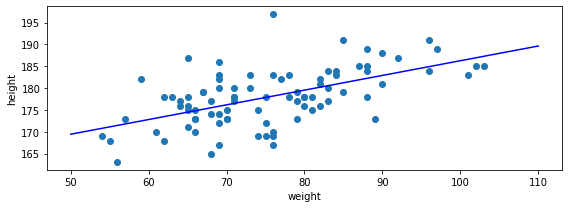

In [27]:
# 일반 최소 자승을 사용해 적합화된 선형 모델의 키와 몸무게 관계
x = np.linspace(50, 110, 25)
y = result.predict({"weight": x})
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, color="blue")
ax.set_xlabel("weight")
ax.set_ylabel("height")
fig.tight_layout()

베이즈 회귀의 최종 결과: 각 모델 매개변수의 한계 분포에 대한 사후 분포

베이즈 모델을 이용해 키와 몸무게 관계를 모델링하기 위해서는 모델의 모든 확률적 변수에 대한 사전 분포도 필요    
-> 여기서는 모든 모델 매개변수의 광범위한 분포를 나타내는 사전 분포 모델로 시작

In [28]:
# 모델의 확률적 요소에 대한 확률 변수 생성 후 그 확률 변수를 특정 매개변수로 표현한 사전 분포에 할당
with mc.Model() as model:
    sigma = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sd=30)
    beta = mc.Normal('beta', 0, sd=5)
    
    height_mu = intercept + beta * data.weight # 기댓값 분포식

    # likelihood function
    mc.Normal('height', mu=height_mu, sd=sigma, observed=data.height)

    # predict
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sd=sigma, shape=len(x)) 

In [29]:
model.vars # 두 모델 매개변수, 오차 분포, 해당하는 키 예측하는 변수

[sigma_interval__ ~ TransformedDistribution,
 intercept ~ Normal,
 beta ~ Normal,
 predict_height ~ Normal]

In [30]:
# 고려된 모델의 한계 사후 분포에서 표본 추출
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(10000, step, start=start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/usr/local/lib/python3.7/dist-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: divide by zero encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe60ebd5d10>,
      dtype=object)

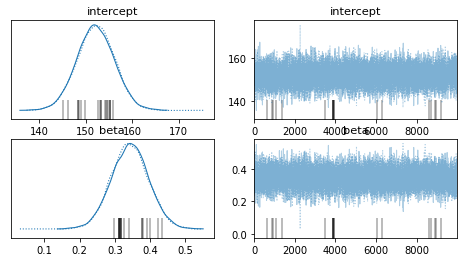

In [31]:
# 선형 모델 절편과 베타 계수의 분포와 표본 추출 추적
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace, var_names=['intercept', 'beta'], axes=axes)

In [32]:
# 분석 결과와 가장 가깝게 일치하는 선형 모델 절편 평균
intercept = trace.get_values("intercept").mean()
intercept

152.14105198488963

In [33]:
# 계수값 평균
beta = trace.get_values("beta").mean()
beta

0.3426894473248613

In [34]:
# statsmodel 분석 결과
result.params

Intercept    152.617348
weight         0.336477
dtype: float64

In [35]:
# 90kg 예상 키 예측
result.predict({"weight": 90})

0    182.9003
dtype: float64

In [36]:
# 90kg에 해당하는 확률적 변수 분포에 대한 평균
weight_index = np.where(x == 90)[0][0]
trace.get_values("predict_height")[:, weight_index].mean()

183.02424958870947

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


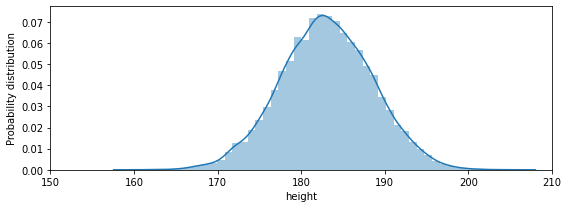

In [37]:
# 몸무게 90kg에 대한 예측 키의 확률 분포
fig, ax = plt.subplots(figsize=(8, 3))

sns.distplot(trace.get_values("predict_height")[:, weight_index], ax=ax)
ax.set_xlim(150, 210)
ax.set_xlabel("height")
ax.set_ylabel("Probability distribution")
fig.tight_layout()

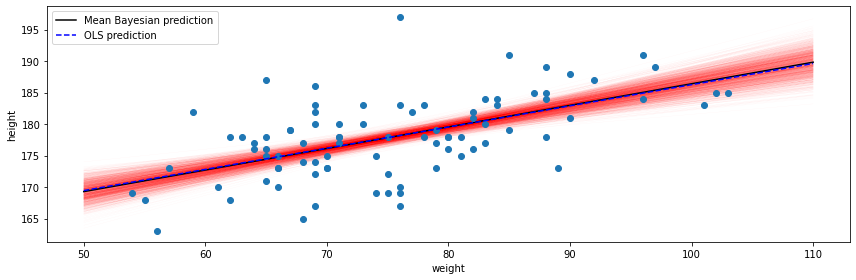

In [38]:
# 키와 몸무게의 관계를 OLS 적합화와 베이즈 모델을 사용한 그래프
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta = trace.get_values("beta")[n]
    ax.plot(x, intercept + beta * x, color='red', lw=0.25, alpha=0.05)

intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()
ax.plot(x, intercept + beta * x, color='k', label="Mean Bayesian prediction")

ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, '--', color="blue", label="OLS prediction")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()

In [39]:
# 모델의 생성과 필요한 확률 변수를 생성하는 작업을 대신해주는 API 이용
with mc.Model() as model:
    mc.glm.GLM.from_formula('height ~ weight', data)
    step = mc.NUTS()
    trace = mc.sample(2000, step)

We recommend to instead use Bambi https://bambinos.github.io/bambi/
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


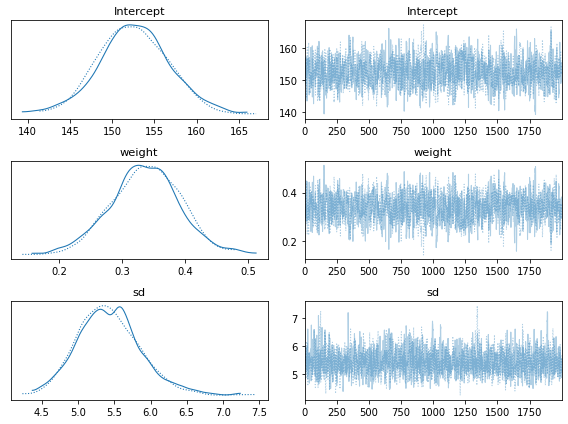

In [40]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, var_names=['Intercept', 'weight', 'sd'], axes=axes)
fig.tight_layout()

베이즈 방법의 장점은 고차원에서 복잡한 모델을 분석할 때 나타남

In [41]:
dataset = sm.datasets.get_rdataset("Davis", "carData")
data = dataset.data.copy()
data = data[data.weight < 110]
data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0) # 0: 남자, 1: 여자

In [42]:
# 통계 모델 정의
with mc.Model() as model:

    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0.0, 5.0
    
    intercept = mc.Normal('intercept', intercept_mu, sd=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sd=beta_sigma, shape=2) # 다중 계층 설정
    error = mc.Uniform('error', 0, 10)

    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight

    mc.Normal('height', mu=height_mu, sd=error, observed=data.height)

In [43]:
# 모델 매개변수
model.vars

[intercept ~ Normal, beta ~ Normal, error_interval__ ~ TransformedDistribution]

In [44]:
# MCMC 표본 추출 알고리즘 호출
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(5000, step, start=start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  """
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


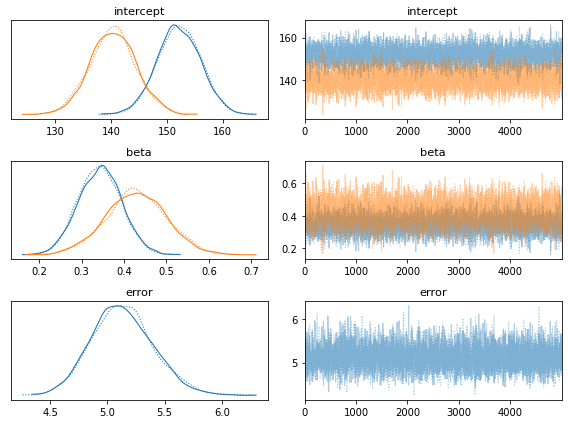

In [45]:
# 모델 매개변수의 다층 모델에 있어 각 변수의 MCMC 표본 추출 추적
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, var_names=['intercept', 'beta', 'error'], axes=axes)
fig.tight_layout()

In [46]:
# 표본 데이터 추출
intercept_m, intercept_f = trace.get_values('intercept').mean(axis=0)
beta_m, beta_f = trace.get_values('beta').mean(axis=0)

# 두 차원에 걸쳐 평균을 하면 전체 데이터셋을 나타내는 절편과 기울기 구할 수 있음
intercept = trace.get_values('intercept').mean()
beta = trace.get_values('beta').mean()

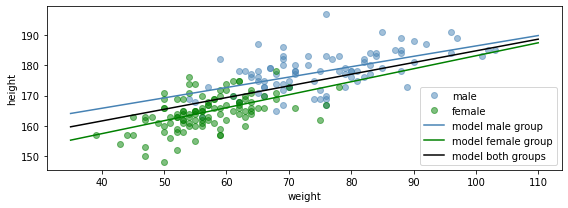

In [47]:
# 남자, 여자의 키와 몸무게
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

mask_m = data.sex == 0
mask_f = data.sex == 1

ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="male", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="female", alpha=0.5)

x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="model male group")
ax.plot(x, intercept_f + x * beta_f, color="green", label="model female group")
ax.plot(x, intercept + x * beta, color="black", label="model both groups")

ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()

남성과 여성 각각의 서로 다른 절편과 기울기를 고려함으로써 모델이 개선됐다는 것을 보여줌